In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import seaborn as sns

In [2]:
# HYPE river segment to be analyzed
riv_seg= '58418'


In [3]:
# Assuming your file is named 'data.txt'
df = pd.read_csv('../project/hype_model/Pobs.txt', sep='\t',index_col=0)

In [4]:
# Read the river and catchment shapefiles
gdf = gpd.read_file('../swe_analysis/smm_tgf_modified/smm_riv.shp')
catchment= gpd.read_file('../swe_analysis/smm_tgf_modified/smm_cat.shp')

In [5]:
# Create a dictionary from 'hru_nhm' and 'seg_nhm' columns in catchment
segment_dict = dict(zip(catchment['seg_nhm'], catchment['hru_nhm']))

In [6]:
# Convert columns to string data type
gdf['seg_nhm'] = gdf['seg_nhm'].astype(str)
gdf['ds_seg_nhm'] = gdf['ds_seg_nhm'].astype(str)

In [7]:
# Create a directed graph
riv_graph = nx.DiGraph()

# Add edges from DataFrame
for idx, row in gdf.iterrows():
    if row['ds_seg_nhm'] != '0':  # Skip if ds_seg_nhm is '0'
        riv_graph.add_edge(row['seg_nhm'], row['ds_seg_nhm'])

# Find upstream segments for given segment
upstream_segments = list(nx.ancestors(riv_graph, riv_seg))

# Add the target segment 'riv_seg' to the upstream segments
upstream_segments.append(riv_seg)

In [8]:
# Convert keys in segment_dict to integers
segment_dict = {int(k): v for k, v in segment_dict.items()}

# Convert values in upstream_segments to integers
upstream_segments = [int(seg) for seg in upstream_segments]

In [9]:
# Convert DataFrame column headers to integers
df.columns = df.columns.astype(int)

In [10]:
# Sum all columns in the list
df['Upstream_Segments_Total'] = df[upstream_segments].sum(axis=1)

In [11]:
# Drop all columns except 'Upstream_Segments_Total'
df = df[['Upstream_Segments_Total']]

In [12]:
# Convert index to datetime
df.index = pd.to_datetime(df.index)

In [13]:
# Filter dates within the range April 1st to July 31st for each year
filtered_df = df[(df.index.month >= 4) & (df.index.month <= 7) & 
                 ((df.index.month != 4) | (df.index.day >= 1)) & 
                 ((df.index.month != 7) | (df.index.day <= 31))]

In [14]:
years= filtered_df.index.year

In [15]:
# Move the original index to a column
filtered_df.reset_index(inplace=True)

In [16]:
# Set years as the index
filtered_df.index = years

In [17]:
# Extract month and day and format as 'MM-DD'
filtered_df['time'] = filtered_df['time'].dt.strftime('%m-%d')

C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_41152\3120471954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = filtered_df['time'].dt.strftime('%m-%d')


In [18]:
# Rename the index level 'time' to avoid ambiguity
filtered_df.index.names = ['Date']

# Pivot the DataFrame
pivot_df = filtered_df.pivot_table(index='time', columns=filtered_df.index, values='Upstream_Segments_Total')

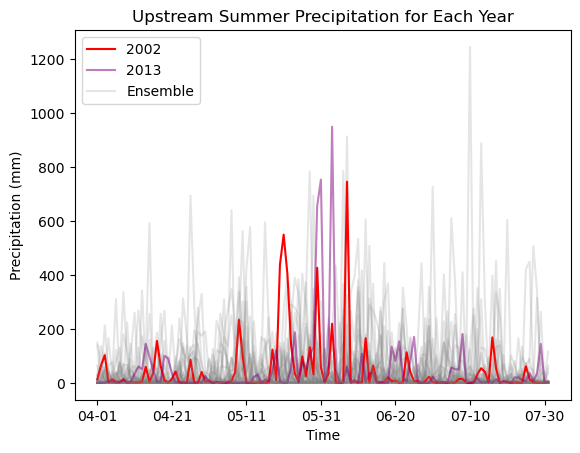

<Figure size 1000x600 with 0 Axes>

In [24]:
# Plot all columns together
for column in pivot_df.columns:
    if column == 2011:
        pivot_df[column].plot(color='red', label='2002')
    elif column == 2013:
        pivot_df[column].plot(color='purple', alpha=0.5, label=str(column))
    else:
        pivot_df[column].plot(color='gray', alpha=0.2, label='Ensemble' if column == pivot_df.columns[-1] else '_nolegend_')

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Upstream Summer Precipitation for Each Year')

# Show the legend
plt.legend()

# Set the plot size
plt.figure(figsize=(10, 6))

# Save the plot with higher DPI
plt.savefig('upstream_precipitation_plot.png', dpi=300)

# Show the plot
plt.show()

In [25]:
# Find the maximum value in pivot_df
max_value = pivot_df.max().max()

# Find the column corresponding to the maximum value
column_of_max_value = pivot_df.max().idxmax()

print("Maximum value:", max_value)
print("Column containing maximum value:", column_of_max_value)

Maximum value: 1244.0999999999997
Column containing maximum value: 1983


In [28]:
# Sum each column
column_sums = pivot_df.sum(axis=0)

# Convert the result to a DataFrame
column_sums_df = pd.DataFrame(column_sums, columns=['Sum'])


In [27]:
# Sort the DataFrame by the 'Sum' column in descending order
column_sums_sorted = column_sums_df.sort_values(by='Sum', ascending=False)

# Display the sorted DataFrame
print(column_sums_sorted)

              Sum
Date             
1989  5732.534810
2013  5686.649924
2011  5589.502751
1993  5114.964818
1991  5005.952368
1995  4459.358938
2016  4388.944980
2008  4298.823979
2002  4235.451399
2010  4222.539938
1992  4188.129715
1987  4171.261424
1982  4170.224759
1986  4089.846367
2007  3979.277935
2001  3729.483891
1990  3708.053199
2000  3601.613453
1999  3504.565080
1994  3454.532586
2015  3435.397371
1983  3431.244879
2012  3263.562571
1981  3067.804061
1998  3041.947561
1997  3005.662473
2009  2885.995379
1980  2546.052428
1996  2522.140660
2004  2447.404684
2003  2441.919209
2006  2250.012344
1984  2230.692555
2018  2223.062190
1988  2206.825644
2014  2145.825066
2005  1919.549735
1985  1799.265608
2017  1152.975720


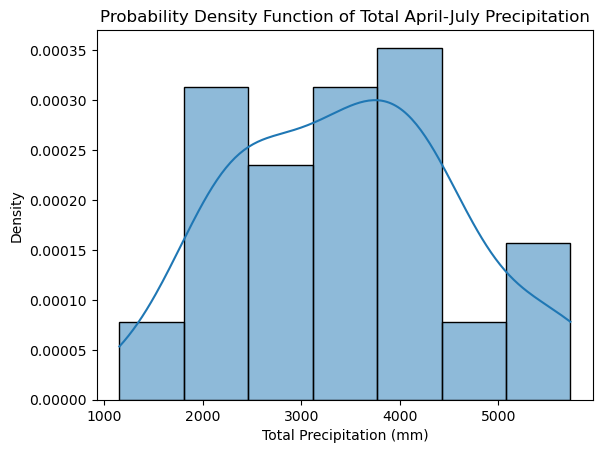

In [23]:
# Plot the PDF using seaborn
sns.histplot(column_sums_df.values.flatten(), kde=True, stat='density')

# Set the labels and title
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Density')
plt.title('Probability Density Function of Total April-July Precipitation')

# Show the plot
plt.show()